This file is to predict the seizure label from my train model

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import time
from pathlib import Path    
from sklearn.metrics import roc_auc_score, roc_curve
plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from models.model_utils import generate_position_encode, load_model_class, trans_batch, eval_model
from data_utils.eeg_load_sz import EEGDataSZ
from data_utils import convert_to_type, get_triple, digitize_data, rec_data, MyDataLoader
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder

In [6]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from tqdm import trange, tqdm

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_device(device)
print(device)

cuda


# Load data and model

## Load model

In [7]:

def _load_trained_model(model_path):
    if isinstance(model_path, str):
        model_path = Path(model_path);
    model_utils = load_pkl_folder2dict(model_path, including=["config*", "*_params*", "loss_save*"]);
    module = load_model_class(model_path);
    model = module.myNet(model_utils.config);
    model.load_state_dict(torch.load(model_path/"model.pth", map_location=torch.device(device)));
    trained_model = model;
    return trained_model, model_utils

In [8]:
model_name = "RAWINPUT_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch6_iter3691"
trained_model, model_utils = _load_trained_model(RES_ROOT/model_name);

Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/RAWINPUT_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch6_iter3691/config.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/RAWINPUT_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch6_iter3691/data_params.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/RAWINPUT_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch6_iter3691/loss_save.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/RAWINPUT_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch6_iter3691/train_params.pkl
number of parameters: 2.5128M


In [9]:
model_utils.keys()

dict_keys(['config', 'data_params', 'loss_save', 'train_params'])

In [10]:
from pprint import pprint
data_params = model_utils.data_params
config = model_utils.config
train_params = model_utils.train_params 
#pprint(data_params)
pprint(config)
pprint(train_params)

{'aux_loss': True,
 'aux_loss_weight': 1,
 'block_size': 256,
 'dropout': 0.5,
 'fs': 90,
 'is_bias': True,
 'is_mask': True,
 'k': 8,
 'move_step': 1,
 'n_head': 8,
 'n_layer': 3,
 'ncls': 2,
 'ndim': 256,
 'nfeature': 19,
 'target_dim': 19}
{'clip': 1,
 'loss_out': 20,
 'lr': 0.0001,
 'lr_gamma': 0.1,
 'lr_step': '10epoch',
 'lr_weight_decay': 0,
 'nepoch': 20,
 'ntrain_batch': 0,
 'save_interval': '1epoch',
 'seed': 0,
 'test_01_ratio': 2,
 'test_batch_size': 8,
 'test_size': 0,
 'train_01_ratio': 1,
 'train_batch_size': 8,
 'train_size': 24,
 'val_01_ratio': 2,
 'val_batch_size': 8,
 'val_loss_out': 50,
 'val_size': 24}


## Load data

In [11]:
verbose = 1
move_params = data_params.move_params
pre_params = data_params.pre_params
rm_params = data_params.rm_params
subset = data_params.subset
test_batch_size = 24

train_data_bckg = EEGDataSZ(
    dataset="train", 
    subset=subset,
    label="bckg", 
    discrete_k=config.k, 
    verbose=verbose, 
    move_params=move_params,
    pre_params=pre_params,
    rm_params=rm_params
    )

train_data_sz = EEGDataSZ(
    dataset="train", 
    subset=subset,
    label="sz", 
    discrete_k=config.k, 
    verbose=verbose, 
    move_params=move_params,
    pre_params=pre_params,
    rm_params=rm_params
    )

val_data_bckg = EEGDataSZ(
    dataset="dev", 
    subset=subset,
    label="bckg", 
    discrete_k=config.k, 
    verbose=verbose, 
    move_params=move_params,
    pre_params=pre_params,
    rm_params=rm_params
    )

val_data_sz = EEGDataSZ(
    dataset="dev", 
    subset=subset,
    label="sz", 
    discrete_k=config.k, 
    verbose=verbose, 
    move_params=move_params,
    pre_params=pre_params,
    rm_params=rm_params
    )

test_data_bckg = EEGDataSZ(
    dataset="eval", 
    subset=subset,
    label="bckg", 
    discrete_k=config.k, 
    verbose=verbose, 
    move_params=move_params,
    pre_params=pre_params,
    rm_params=rm_params
    )

test_data_sz = EEGDataSZ(
    dataset="eval", 
    subset=subset,
    label="sz", 
    discrete_k=config.k, 
    verbose=verbose, 
    move_params=move_params,
    pre_params=pre_params,
    rm_params=rm_params
    )


train_data_bckg_loader = MyDataLoader(train_data_bckg, 
                                      batch_size=test_batch_size*train_params.train_01_ratio, 
                                      shuffle=True,
                                      seed=train_params.seed)
train_data_sz_loader = MyDataLoader(train_data_sz, 
                                    batch_size=test_batch_size,
                                    shuffle=True, 
                                    seed=train_params.seed)
val_data_bckg_loader = MyDataLoader(val_data_bckg, 
                                      batch_size=test_batch_size*train_params.val_01_ratio,
                                      shuffle=False, 
                                      seed=train_params.seed)
val_data_sz_loader = MyDataLoader(val_data_sz, 
                                    batch_size=test_batch_size,
                                    shuffle=False, 
                                    seed=train_params.seed)

test_data_bckg_loader = MyDataLoader(test_data_bckg, 
                                      batch_size=test_batch_size*train_params.test_01_ratio,
                                      shuffle=False, 
                                      seed=train_params.seed)
test_data_sz_loader = MyDataLoader(test_data_sz, 
                                    batch_size=test_batch_size,
                                    shuffle=False, 
                                    seed=train_params.seed)
                                
print(f"Num of data: train_bckg: {len(train_data_bckg)}, train_sz: {len(train_data_sz)}", 
      f"val_bckg: {len(val_data_bckg)}, val_sz: {len(val_data_sz)}", 
      f"test_bckg: {len(test_data_bckg)}, test_sz: {len(test_data_sz)}")

Num of data: train_bckg: 594733, train_sz: 29535 val_bckg: 207134, val_sz: 10798 test_bckg: 114923, test_sz: 8862


# Analysis 

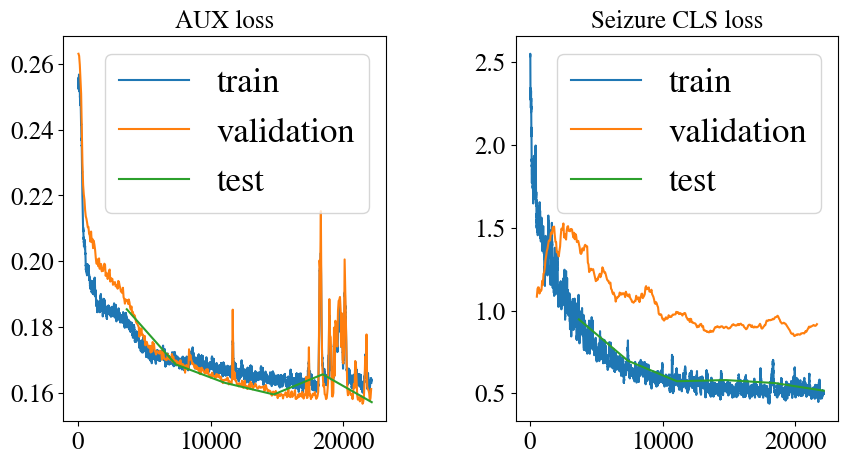

In [14]:
from copy import deepcopy
losses = deepcopy(model_utils.loss_save)
_item_mean_fn = lambda x: [np.mean(v) for v in x]

def move_average(vec, window=100):
    vec = np.convolve(vec, np.ones(window)/window, mode="valid")
    return vec

if "aux_loss" in losses.train.keys():
    plt.subplot(121)
    plt.title("AUX loss")
    plt.plot(move_average(losses.train["niter"], window=50), 
             move_average(losses.train["aux_loss"], window=50), 
             label="train")
    plt.plot(losses.val["niter"], 
             _item_mean_fn(losses.val["aux_loss"]), 
             label="validation")
    plt.plot(losses.test["niter"], 
             _item_mean_fn(losses.test["aux_loss"]), 
             label="test")
    plt.legend()
    #
    plt.subplot(122)
plt.title("Seizure CLS loss")
plt.plot(move_average(losses.train["niter"], window=50),
         move_average(losses.train["cls_loss"], window=50),
         label="train")
plt.plot(move_average(losses.val["niter"], window=20), 
         move_average(_item_mean_fn(losses.val["cls_loss"]), window=20),
         label="validation")
plt.plot(losses.test["niter"], 
        _item_mean_fn(losses.test["cls_loss"]), 
         label="test")
plt.legend()

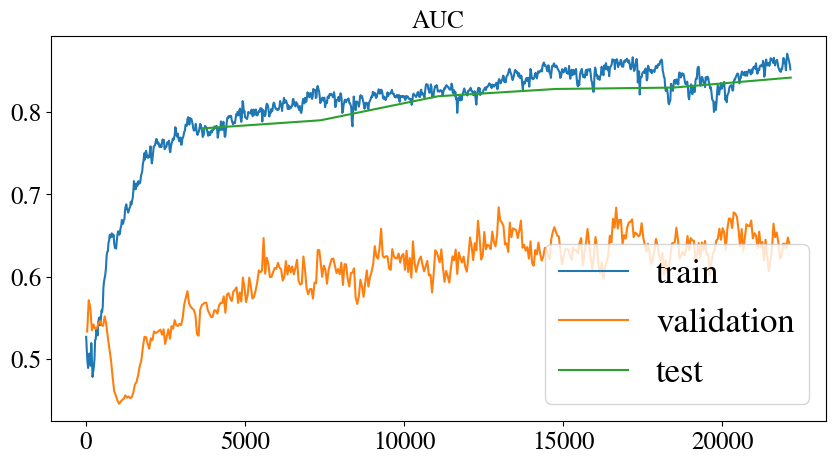

In [16]:
plt.title("AUC")
plt.plot(
    losses.train["niter_auc"],
    losses.train["auc"], 
    label="train"
)
plt.plot(
    losses.val["niter"],
    losses.val["auc"], 
    label="validation"
)
plt.plot(
    losses.test["niter"],
    losses.test["auc"], 
    label="test"
)
plt.legend()

In [22]:
n_test_batch = 0
res= eval_model(
    trained_model, 
    val_data_sz_loader, 
    val_data_bckg_loader, 
    n_batch=n_test_batch,
    random=False,
    verbose=True
);

100%|█████████████████████████████████████████| 449/449 [42:24<00:00,  5.67s/it]


In [23]:
res

defaultdict(list,
            {'probs_sz': array([0.9399282 , 0.96924088, 0.98863124, ..., 0.68943604, 0.79089555,
                    0.71324944]),
             'labs_sz': array([1, 1, 1, ..., 0, 0, 0]),
             'auc': 0.6773733253155712})

Text(0.5, 1.0, 'ROC Curve (AUC=0.6774)')

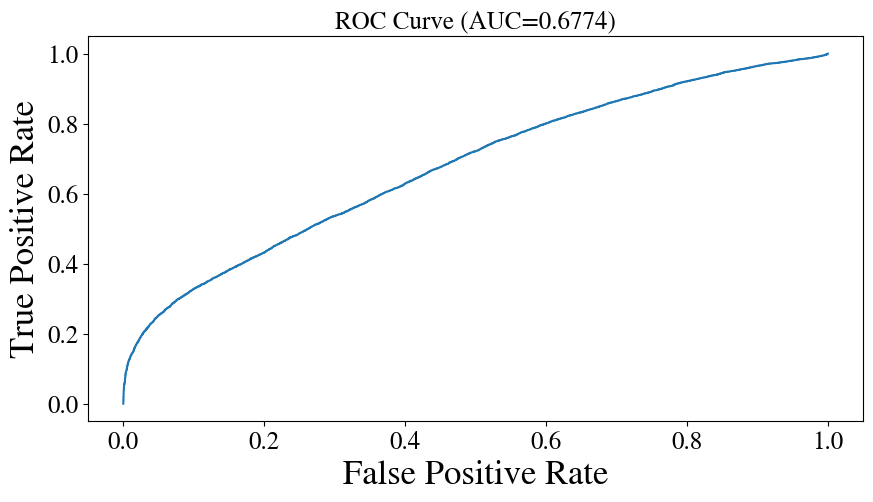

In [26]:
# get the AUC of the model and draw the ROC curve

fpr, tpr, thresholds = roc_curve(res["labs_sz"], res["probs_sz"])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={res["auc"]:.4f})')

In [31]:
res["probs_sz"][res["labs_sz"]==1].mean(), res["probs_sz"][res["labs_sz"]==0].mean()

(0.4668760139299435, 0.24849697015898797)